<a href="https://colab.research.google.com/github/preritt/KProj/blob/master/Conv8_1LayerVGG11_Transfer_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load standard libraries

In [0]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn import preprocessing
from keras import losses
from keras.models import model_from_json
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
from keras.utils.vis_utils import plot_model


In [0]:
keras.backend.clear_session()

## Load image data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


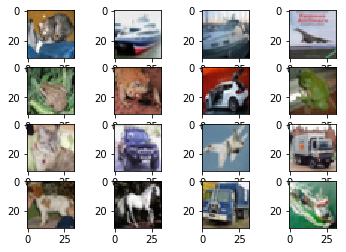

In [0]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.datasets import cifar10
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])


## Create Function to get data corresponding to three labels

In [0]:
# This function takes the entire traaining data and test data and corresponding categorical label and returns the corresponding data in class indices
def getThreeClassesTrainTest(class_indices,train_data,train_labels,test_data,test_labels):
  all_train_data = []
  all_train_data_label = []
  all_test_data = []
  all_test_data_label = []
  for ind in class_indices:
    this_class_location_train =  np.where(train_labels==ind)[0] # train_labels[train_labels == ind]
    this_class_data_train = train_data[this_class_location_train,:]
    this_class_data_train_label = train_labels[this_class_location_train]
#     print(this_class_location_train)
    
    this_class_location_test = np.where(test_labels==ind)[0] #test_labels[test_labels == ind]
    this_class_data_test = test_data[this_class_location_test,:]
    this_class_data_test_label = test_labels[this_class_location_test]
    
    all_train_data.append(this_class_data_train)
    all_test_data.append(this_class_data_test)
    all_train_data_label.append(this_class_data_train_label)
    all_test_data_label.append(this_class_data_test_label)
    
  train_data_three = all_train_data[0]
  train_label_three = all_train_data_label[0]
  test_data_three = all_test_data[0]
  test_label_three = all_test_data_label[0]
  
  for j in range(1,len(class_indices)):
    train_data_three = np.concatenate((train_data_three,all_train_data[j]))
    train_label_three = np.concatenate((train_label_three,all_train_data_label[j]))

    test_data_three = np.concatenate((test_data_three,all_test_data[j]))
    test_label_three = np.concatenate((test_label_three,all_test_data_label[j]))
#   print(train_label_three.shape)
  train_label_three = np.reshape(train_label_three,newshape=(-1,))
  test_label_three = np.reshape(test_label_three,newshape=(-1,))
  return train_data_three, train_label_three, test_data_three,test_label_three

## Get data for three classes using getThreeClassesTrainTest function

In [0]:
# train_three_data,train_three_label,test_three_data,test_three_label = getThreeClassesTrainTest([ 0,3,5 ],x_train,y_train,x_test,y_test)

In [0]:
train_three_data,train_three_label,test_three_data,test_three_label = (np.load('train_three_data_saved.npy'),
                                                                      np.load('train_three_label_saved.npy'),
                                                                      np.load('test_three_data_saved.npy'),
                                                                      np.load('test_three_label_saved.npy'))

In [0]:
train_three_label

array([0, 3, 5, ..., 0, 5, 5], dtype=uint8)

In [0]:
test_three_label

array([3, 5, 0, ..., 5, 0, 5])

(array([5000.,    0.,    0.,    0.,    0.,    0., 5000.,    0.,    0.,
        5000.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

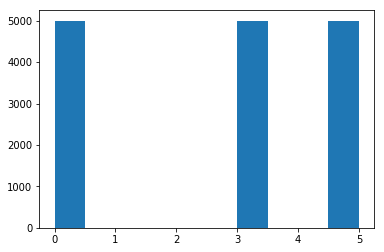

In [0]:
plt.hist(train_three_label)

(array([1000.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,
        1000.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

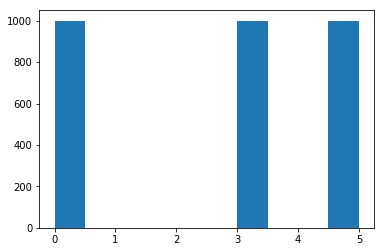

In [0]:
plt.hist(test_three_label)

In [0]:
# train_three_data, train_three_label = shuffle(train_three_data, train_three_label )
# test_three_data,test_three_label = shuffle(test_three_data,test_three_label )

In [0]:
le = preprocessing.LabelEncoder()
le.fit_transform(train_three_label)
train_three_label_cat = le.transform(train_three_label)
test_three_label_cat = le.transform(test_three_label)
train_three_label_one_hot = to_categorical(train_three_label_cat)
test_three_label_one_hot = to_categorical(test_three_label_cat)

In [0]:
# split train data and to create validation data
train_X,valid_X,train_ground,valid_ground = train_test_split(train_three_data,
                                                             train_three_label_one_hot,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
num_classes = test_three_label_one_hot.shape[1]

## Define the model

In [0]:
x, y = 32, 32
inChannel = 3
input_img = Input(shape = (x, y, inChannel))
ep = 10 
weight_decay = 1e-4

In [0]:
def cifar10Classifier(input_img):
  
  conv1_1 = (Conv2D(64, (3,3),name = 'conv1_1' ,padding='same', 
                    kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:],
                    activation='relu'))(input_img)
  conv1_2 = BatchNormalization(name = 'conv1_2')(conv1_1)
  pool1_3 = MaxPooling2D(pool_size=(2, 2), name = 'pool1_3')(conv1_2) #14 x 14 x 32
  conv2_1 = (Conv2D(128, (3,3),name = 'conv2_1' ,padding='same',
                    activation= 'relu',kernel_regularizer=regularizers.l2(weight_decay)))(pool1_3)
  conv2_2 = BatchNormalization(name = 'conv2_2')(conv2_1)
  pool2_3 = MaxPooling2D(pool_size=(2, 2), name = 'pool2_3')(conv2_2) #14 x 14 x 32
  
  conv3_1 = (Conv2D(256, (3,3), padding='same',name = 'conv3_1',
                    kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool2_3)
  conv3_2 = BatchNormalization(name = 'conv3_2')(conv3_1)
  conv4_1 = (Conv2D(256, (3,3), padding='same',name = 'conv4_1' ,activation= 'relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))(conv3_2)
  conv4_2 = BatchNormalization(name = 'conv4_2')(conv4_1)
  pool4_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool4_2')(conv4_2) #14 x 14 x 32
  
  conv5_1 = (Conv2D(512, (3,3), padding='same',name = 'conv5_1',
                    kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool4_2)
  conv5_2 = BatchNormalization(name = 'conv5_2')(conv5_1)
  conv6_1 = (Conv2D(512, (3,3), padding='same',name = 'conv6_1' ,activation= 'relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))(conv5_2)
  conv6_2 = BatchNormalization(name = 'conv6_2')(conv6_1)
  pool6_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool6_2')(conv6_2) #14 x 14 x 32
  
  conv7_1 = (Conv2D(512, (3,3), padding='same',name = 'conv7_1',
                    kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool6_2)
  conv7_2 = BatchNormalization(name = 'conv7_2')(conv7_1)
  conv8_1 = (Conv2D(512, (3,3), padding='same',name = 'conv8_1' ,activation= 'relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))(conv7_2)
  conv8_2 = BatchNormalization(name = 'conv8_2')(conv8_1)
  pool8_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool8_2')(conv8_2) #14 x 14 x 32


  flat = Flatten()(pool8_2)
  fc1 = Dense(4096, activation='relu', name = 'fc1')(flat)
  fc2 = Dense(4096, activation='relu', name = 'fc2')(fc1)
  fc3 = Dense(1000, activation='relu', name = 'fc3')(fc2)


  
  out = Dense(num_classes, activation='softmax', name = 'out')(fc3)
  
  return out

## Define functions for calculation of DI score
getDIScoreOfLayer(layer_output, true_labels), 
getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels)


In [0]:
def getDIScoreOfLayer(layer_output, true_labels):
  # computeScatterMatrix
  rho = 1e-6
  mu = layer_output.mean(axis=0)
#   print(mu.shape)
  mu = mu.reshape((1,-1))
  centered_data = layer_output - mu
  S_bar = np.matmul(centered_data.T,centered_data)
  # compute between class matrix
  total_classes = true_labels.max()
  S_B = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  S_W = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  unique_classes = np.unique(true_labels)
  unique_classes_list = np.ndarray.tolist(unique_classes)
  for l in unique_classes_list:
    class_l_index = np.where(true_labels == l)
    class_l_output = layer_output[class_l_index[0],:]
    mu_l = class_l_output.mean(axis=0)
    mu_l = mu_l.reshape((1,-1))
    total_examples_this_class = class_l_index[0].shape   
    ss = mu_l - mu
    S_B = S_B + total_examples_this_class*np.matmul((mu_l - mu).T,(mu_l - mu))

  DI_Score = np.trace(np.matmul(np.linalg.inv(S_bar + rho*np.eye(S_bar.shape[0])),S_B))
  return DI_Score

In [0]:
def getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels):
  # computeScatterMatrix
  number_of_filters = cnn_outputs.shape[3]
  cnn_di_scores = []
  for filt in range(0,number_of_filters):
    outputs_filter = cnn_outputs[:,:,:,filt]
    outputs_filter_reshaped = np.reshape(outputs_filter, newshape=(cnn_outputs.shape[0],-1))
    this_filter_score = getDIScoreOfLayer(outputs_filter_reshaped, true_labels)
    cnn_di_scores.append(this_filter_score)
  return cnn_di_scores

## define a function to get and plot di score of a layer. It takes inputs - trained model, layer name to get DI scores and returns a plot with some statistics

In [0]:
def createCNNLayerDIScorePlot(trained_model, layer_name, data_to_use = train_three_data , data_label =train_three_label ):
#   print(trained_model.layers)
#   get_cnn1_output_function = K.function([trained_model.layers[0].input],
#                                   [trained_model.get_layer(layer_name).output])   #get_layer test_three_label
  
  model = trained_model
  intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
  cnn1_output = intermediate_layer_model.predict(data_to_use)
#   cnn1_output = get_cnn1_output_function([data_to_use])[0]
  di_scores = getDIScoreOfLayerCNNLayer(cnn1_output, data_label)
  # plot DI score
  y_pos  = np.arange(len(di_scores))
  plt.bar(y_pos, di_scores, align='center', alpha=0.5)
  plt.xlabel('FilterNumber')
  plt.ylabel('DI Score')

  print('Mean of DI SCore: ',np.mean(di_scores))
  print('STD of DI Score: ', np.std(di_scores))
  print('MAX of DI Score: ', np.max(di_scores))
#   plt.title('DI score - Data - D_L, Network -N_L ' + layer_name)
  plt.title('DI score ' + layer_name)

#   plt.ylim([0,1])
  return di_scores

## load pretrained model

In [0]:
loaded_model_low_accuracy = keras.models.load_model('vgg16lowAccuracyModelDataV3.h5')
loaded_model_high_accuracy = keras.models.load_model('vgg16HighAccuracyModelData.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
loaded_model_low_accuracy.evaluate(valid_X, valid_ground, verbose=0)

#[0.3284807046254476, 0.923]

[0.45540413602193197, 0.8660000001589457]

In [0]:
temp_model = keras.models.load_model('vgg16lowAccuracyModelDataV3.h5')
temp_model.evaluate(valid_X, valid_ground, verbose=0)

[0.45540413983662925, 0.8660000001589457]

In [0]:
valid_ground

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [0]:
loaded_model_low_accuracy.evaluate(test_three_data, test_three_label_one_hot, verbose=0)

[0.45106768774986267, 0.8799999998410543]

In [0]:
# loaded_model_low_accuracy.load_weights('weights.hdf5')
# loaded_model_low_accuracy.evaluate(valid_X, valid_ground, verbose=0)
loaded_model_high_accuracy.evaluate(valid_X, valid_ground, verbose=0)


[2.825879507700602, 0.3953333332538605]

In [0]:
loaded_model_high_accuracy.evaluate(test_three_data, test_three_label_one_hot, verbose=0)

[3.126735860188802, 0.3673333334128062]

In [0]:
loaded_model_low_accuracy.evaluate(test_three_data, test_three_label_one_hot, verbose=0)

[0.45106768774986267, 0.8799999998410543]

In [0]:
loaded_model_low_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
conv1_2 (BatchNormalization) (None, 32, 32, 64)        256       
_________________________________________________________________
pool1_3 (MaxPooling2D)       (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2_2 (BatchNormalization) (None, 16, 16, 128)       512       
_________________________________________________________________
pool2_3 (MaxPooling2D)       (None, 8, 8, 128)         0         
__________

## Create a plot for DI score using function createCNNLayerDIScorePlot()

#### On train data

In [0]:
# layer_name = 'conv2d_2'
# model = loaded_model_low_accuracy
# intermediate_layer_model = Model(i4nputs=model.input,
#                                  outputs=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(train_three_data)

Mean of DI SCore:  0.8694144080993281
STD of DI Score:  0.6205526663901321
MAX of DI Score:  1.5949378094135989


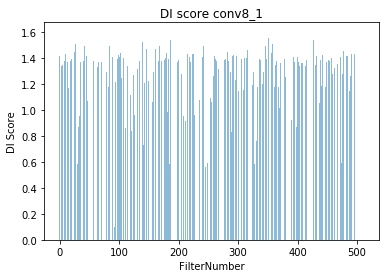

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
# layer_names = ['conv2_1']
layer_names = ['conv8_1']
all_di_acores_low_accuracy = []
for lay in layer_names:
  this_di_score_low_accuracy_model = createCNNLayerDIScorePlot(loaded_model_low_accuracy, lay)
  all_di_acores_low_accuracy.append(this_di_score_low_accuracy_model)
# discores_low_acc_model = createCNNLayerDIScorePlot(loaded_model_low_accuracy, layer_name)

In [0]:
# discores_low_acc_model

In [0]:
# np.sort(discores_low_acc_model)

Mean of DI SCore:  0.09890966478271793
STD of DI Score:  0.08029777448636094
MAX of DI Score:  0.2144610349284688


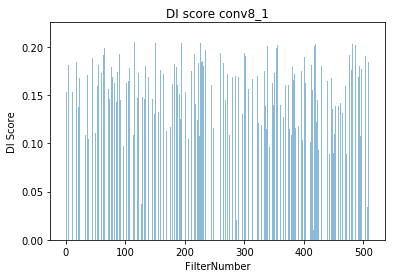

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
#layer_name = 'conv2d_2'

# discores_high_acc_model = createCNNLayerDIScorePlot(loaded_model_high_accuracy, layer_name)
all_di_acores_high_accuracy = []
for lay in layer_names:
  this_di_score_high_accuracy_model = createCNNLayerDIScorePlot(loaded_model_high_accuracy, lay)
  all_di_acores_high_accuracy.append(this_di_score_high_accuracy_model)

## Pick top 10 DI scores

#### On validation data

In [0]:
valid_ground_actual = np.argmax(valid_ground, axis=1)
# valid_ground_actual.shape
# data_to_use = train_three_data , data_label =train_three_label

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
#layer_name = 'conv2d_2'
# discores_low_acc_model_valid = createCNNLayerDIScorePlot(loaded_model_low_accuracy,
#                                                    layer_name, data_to_use=valid_X, data_label=valid_ground_actual)

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
#layer_name = 'conv2d_2'

# discores_high_acc_model_valid = createCNNLayerDIScorePlot(loaded_model_high_accuracy,
#                                                    layer_name, data_to_use=valid_X, data_label=valid_ground_actual)

In [0]:
# np.sort(discores_high_acc_model)

#### Pick top channels from the layers selected

In [0]:
topChoose = True


In [0]:
for i,d in enumerate(all_di_acores_high_accuracy):
  print(len(d),i)

512 0


In [0]:
Ks = [128]

In [0]:
copied_low_accuracy_model = loaded_model_low_accuracy

In [0]:
copied_high_accuracy_model = loaded_model_high_accuracy

In [0]:
# low_accuracy_model_weight.shape

In [0]:
for l,DIs in enumerate(all_di_acores_high_accuracy):
  this_layer_name = layer_names[l]
  this_high_accuracy_di_scores = all_di_acores_high_accuracy[l]
  this_high_accuracy_di_scores_sorted = np.argsort(this_high_accuracy_di_scores)
  this_high_accuracy_di_scores_sorted_list = np.ndarray.tolist(this_high_accuracy_di_scores_sorted)
  top_channels = this_high_accuracy_di_scores_sorted_list[-Ks[l]:]
  
  # do same thing for lowest DIs
  this_low_accuracy_di_scores = all_di_acores_low_accuracy[l]
  this_low_accuracy_di_scores_sorted = np.argsort(this_low_accuracy_di_scores)
  this_low_accuracy_di_scores_sorted_list = np.ndarray.tolist(this_low_accuracy_di_scores_sorted)
  bottom_channels = this_low_accuracy_di_scores_sorted_list[0:Ks[l]]
  
  # now replace the weights
  low_accuracy_model_weights_bias = copied_low_accuracy_model.get_layer(this_layer_name).get_weights()
  high_accuracy_model_weights_bias = copied_high_accuracy_model.get_layer(this_layer_name).get_weights()

  low_accuracy_model_weight,low_accuracy_model_bias = low_accuracy_model_weights_bias[0],low_accuracy_model_weights_bias[1]
  high_accuracy_model_weight,high_accuracy_model_bias = high_accuracy_model_weights_bias[0],high_accuracy_model_weights_bias[1]
#   print(low_accuracy_model_weight.shape,low_accuracy_model_bias.shape)
  low_accuracy_model_weight[:,:,:,bottom_channels] = high_accuracy_model_weight[:,:,:,top_channels]
#   print(bottom_channels)
  high_accuracy_model_bias[bottom_channels] = high_accuracy_model_bias[top_channels]
  
  copied_low_accuracy_model.get_layer(this_layer_name).set_weights([low_accuracy_model_weight, high_accuracy_model_bias])

In [0]:
# high_accuracy_model_weights_bias.shape

In [0]:
# high_accuracy_model_bias

In [0]:

# # (discores_high_acc_model)
# K= 50 # how many channels to pick
# high_acc_di_sorted = np.argsort(discores_high_acc_model)
# high_acc_di_sorted_list = np.ndarray.tolist(high_acc_di_sorted)
# top_channels = high_acc_di_sorted_list[-K:]#np.random.choice(32,K)#
# print('Top Channels: ',top_channels)


# low_acc_di_sorted = np.argsort(discores_low_acc_model)
# low_acc_di_sorted_list = np.ndarray.tolist(low_acc_di_sorted)
# low_channels = low_acc_di_sorted_list[0:K]#np.random.choice(32,K)
# print('Low Channels: ', low_channels)

#####  get low accuracy DI channels

In [0]:
# discores_low_acc_model

In [0]:
# plt.plot(discores_low_acc_model,'-*')

In [0]:
# total_channels = len(discores_high_acc_model)
# total_channels

In [0]:
enable_training = True

In [0]:
# returns 
'''
def highAccuracyModelTillConv2(input_img): 
  conv1_1 = (Conv2D(32, (3,3), padding='same',
                    kernel_regularizer=regularizers.l2(weight_decay), 
                    input_shape=x_train.shape[1:], activation='elu', trainable = enable_training,
                    name = 'HighAccuracyConv1'))(input_img)
  conv1_2 = BatchNormalization(name = 'HighAccuracyBN1',
                              trainable = enable_training)(conv1_1)
  conv2_1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',trainable = enable_training,
                    name = 'HighAccuracyConv2',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)
#   conv2_2 = BatchNormalization(name = 'HighAccuracyBN2',
#                               trainable = enable_training)(conv2_1)  
  
  return conv2_1
'''

"\ndef highAccuracyModelTillConv2(input_img): \n  conv1_1 = (Conv2D(32, (3,3), padding='same',\n                    kernel_regularizer=regularizers.l2(weight_decay), \n                    input_shape=x_train.shape[1:], activation='elu', trainable = enable_training,\n                    name = 'HighAccuracyConv1'))(input_img)\n  conv1_2 = BatchNormalization(name = 'HighAccuracyBN1',\n                              trainable = enable_training)(conv1_1)\n  conv2_1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',trainable = enable_training,\n                    name = 'HighAccuracyConv2',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)\n#   conv2_2 = BatchNormalization(name = 'HighAccuracyBN2',\n#                               trainable = enable_training)(conv2_1)  \n  \n  return conv2_1\n"

In [0]:
copied_low_accuracy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
conv1_2 (BatchNormalization) (None, 32, 32, 64)        256       
_________________________________________________________________
pool1_3 (MaxPooling2D)       (None, 16, 16, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2_2 (BatchNormalization) (None, 16, 16, 128)       512       
_________________________________________________________________
pool2_3 (MaxPooling2D)       (None, 8, 8, 128)         0         
__________

In [0]:
from keras.layers import Dense, Concatenate, Input, Lambda


In [0]:
# def cifar10ClassifierTransfer(input_img):
  
#   conv1_1 = (Conv2D(64, (3,3),name = 'conv1_1' ,padding='same', 
#                     kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:],
#                     activation='relu'))(input_img)
#   conv1_2 = BatchNormalization(name = 'conv1_2')(conv1_1)
#   pool1_3 = MaxPooling2D(pool_size=(2, 2), name = 'pool1_3')(conv1_2) #14 x 14 x 32
#   conv2_1 = (Conv2D(128, (3,3),name = 'conv2_1' ,padding='same',
#                     activation= 'relu',kernel_regularizer=regularizers.l2(weight_decay)))(pool1_3)
#   conv2_2 = BatchNormalization(name = 'conv2_2')(conv2_1)
#   pool2_3 = MaxPooling2D(pool_size=(2, 2), name = 'pool2_3')(conv2_2) #14 x 14 x 32
  
#   conv3_1 = (Conv2D(256, (3,3), padding='same',name = 'conv3_1',
#                     kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool2_3)
#   conv3_2 = BatchNormalization(name = 'conv3_2')(conv3_1)
#   conv4_1 = (Conv2D(256, (3,3), padding='same',name = 'conv4_1' ,activation= 'relu',
#                     kernel_regularizer=regularizers.l2(weight_decay)))(conv3_2)
#   conv4_2 = BatchNormalization(name = 'conv4_2')(conv4_1)
#   pool4_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool4_2')(conv4_2) #14 x 14 x 32
  
#   conv5_1 = (Conv2D(512, (3,3), padding='same',name = 'conv5_1',
#                     kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool4_2)
#   conv5_2 = BatchNormalization(name = 'conv5_2')(conv5_1)
#   conv6_1 = (Conv2D(512, (3,3), padding='same',name = 'conv6_1' ,activation= 'relu',
#                     kernel_regularizer=regularizers.l2(weight_decay)))(conv5_2)
#   conv6_2 = BatchNormalization(name = 'conv6_2')(conv6_1)
#   pool6_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool6_2')(conv6_2) #14 x 14 x 32
  
#   conv7_1 = (Conv2D(512, (3,3), padding='same',name = 'conv7_1',
#                     kernel_regularizer=regularizers.l2(weight_decay), activation='relu'))(pool6_2)
#   conv7_2 = BatchNormalization(name = 'conv7_2')(conv7_1)
#   conv8_1 = (Conv2D(512, (3,3), padding='same',name = 'conv8_1' ,activation= 'relu',
#                     kernel_regularizer=regularizers.l2(weight_decay)))(conv7_2)
#   conv8_2 = BatchNormalization(name = 'conv8_2')(conv8_1)
#   pool8_2 = MaxPooling2D(pool_size=(2, 2), name = 'pool8_2')(conv8_2) #14 x 14 x 32


#   flat = Flatten()(pool8_2)
#   fc1 = Dense(4096, activation='relu', name = 'fc1')(flat)
#   fc2 = Dense(4096, activation='relu', name = 'fc2')(fc1)
#   fc3 = Dense(1000, activation='relu', name = 'fc3')(fc2)


  
#   out = Dense(num_classes, activation='softmax', name = 'out')(fc3)
  
#   return out

In [0]:
# top_channels

In [0]:
# #high_acc_output = highAccuracyModelTillConv2(input_img)
# modelFilt = Model(input_img, 
#               cifar10ClassifierTransfer(input_img))
# #data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     )
# datagen.fit(train_three_data)
 
# #training
# batch_size = 64
 
# opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# # model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

# modelFilt.compile(loss=losses.categorical_crossentropy, optimizer=opt_rms, metrics=['accuracy'])

# modelFilt.summary()
 

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_three_data)
# #training
batch_size = 64

In [0]:
plot_model(copied_low_accuracy_model, to_file="FiltModel.png", show_shapes=True, show_layer_names=True)

In [0]:
# loaded_model_high_accuracy.summary()

## set predetermined weights

In [0]:
# top_channels

In [0]:
# top_channels

#### # get low accuracy DI channel - stored in low_channels

```
# This is formatted as code
```

s

In [0]:

# loaded_model_high_accuracy.get_layer(layer_name).get_weights()[0].shape

## Get filter weights for top K10 DI scores

In [0]:
# # set weights of high accuracy model for channels not used to 0 [9, 25, 19, 29, 5, 7, 26, 28, 17, 23]
# high_acc_conv2_weights = loaded_model_high_accuracy.get_layer(layer_name).get_weights()
# # temp_weights = np.zeros_like(high_acc_conv2_weights[0].shape[0])
# temp_weights_top_10_DI = np.zeros(shape = (high_acc_conv2_weights[0].shape[0],high_acc_conv2_weights[0].shape[1],high_acc_conv2_weights[0].shape[2],K))
# h,w,d,n = high_acc_conv2_weights[0].shape
# j = 0
# for ch in range(0,n):
#   if ch in top_channels:
#     temp_weights_top_10_DI[:,:,:,j] = high_acc_conv2_weights[0][:,:,:,ch]
#     j = j+1
    
  
# # (high_acc_conv2_weights[0].shape)

In [0]:
# temp_weights_top_10_DI.shape

In [0]:
# top_channels

In [0]:
# temp_bias_top_10_DI = np.zeros(shape = (K,))
# # temp_bias = high_acc_conv2_weights[1]

# # bias_shape = high_acc_conv2_weights[1].shape
# j = 0
# for ch in range(0,high_acc_conv2_weights[1].shape[0]):
# #   print (ch)
#   if ch in top_channels:
#     temp_bias_top_10_DI[j] = high_acc_conv2_weights[1][ch]
#     j = j+1

In [0]:
# temp_bias
# weights_to_assign_fromHighAcc = [temp_weights_top_10_DI,temp_bias_top_10_DI]

In [0]:
# temp_weights_top_10_DI.shape

In [0]:
# high_acc_conv2_weights[1].shape

In [0]:
# modelFilt.get_layer('lowAccuracyModelConv1_1').set_weights(loaded_model_low_accuracy.get_layer('conv2d_1').get_weights())
# modelFilt.get_layer('lowAccuracyModelBN1').set_weights(loaded_model_low_accuracy.get_layer('batch_normalization_1').get_weights())
# # modelFilt.get_layer('HighAccuracyConv2').set_weights(loaded_model_high_accuracy.get_layer('conv2d_2').get_weights())
# modelFilt.get_layer('lowAccuracyModelConv2_1').set_weights(loaded_model_low_accuracy.get_layer('conv2d_2').get_weights())

In [0]:
# loaded_model_low_accuracy.summary()

In [0]:
# # preset the weights
# for l1,l2 in zip(modelFilt.layers,loaded_model_low_accuracy.layers):
#     l1.set_weights(l2.get_weights())

In [0]:
# layer_to_replace = layer_name
# low_acc_conv2d_weights_bias = modelFilt.get_layer(layer_to_replace).get_weights()
# low_acc_conv2d_weights = low_acc_conv2d_weights_bias[0]
# low_acc_conv2d_wbias= low_acc_conv2d_weights_bias[1]


In [0]:
# temp_bias_top_10_DI.shape

In [0]:
# # now change weights for layers corresponding to lowest DI scores
# orig_weights = np.copy(low_acc_conv2d_weights)
# j = 0
# for ch in range(0,orig_weights.shape[3]):
#   if ch in low_channels:
# #     print(ch)
#     orig_weights[:,:,:,ch] = temp_weights_top_10_DI[:,:,:,j]
#     j = j+1
# # orig_weights.shape

In [0]:
# orig_bias = np.copy(low_acc_conv2d_wbias)
# j = 0
# for ch in range(0,orig_bias.shape[0]):
#   if ch in low_channels:
# #     print(ch)
#     orig_bias[ch] = temp_bias_top_10_DI[j]
#     j = j+1

In [0]:
# new_wt_bias_conv2d1 = [orig_weights,orig_bias]

#### Overwrite weights fow low DI with high DI

In [0]:
# modelFilt.get_layer(layer_to_replace).set_weights(new_wt_bias_conv2d1)

In [0]:
# loaded_model_low_accuracy.layers[5]

In [0]:
# modelFilt.summary()

#### # now replace weights in conv2d layer for filters correspondng to lowest 10 DI scores

In [0]:
file_save_name = 'weights_top_k_model2.hdf5'
mcp_save = ModelCheckpoint(file_save_name, save_best_only=True, monitor='val_acc', mode='auto')

In [0]:
def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [0]:
copied_low_accuracy_model.evaluate(valid_X, valid_ground, verbose=0)

[11.013150327046713, 0.3246666665871938]

In [0]:
copied_low_accuracy_model.fit_generator(datagen.flow(train_X, train_ground, batch_size=batch_size),\
                    steps_per_epoch=train_X.shape[0] // batch_size,epochs=40,\
                    verbose=1,validation_data=(valid_X,valid_ground),
                    shuffle = True,callbacks=[mcp_save,LearningRateScheduler(lr_schedule)])

Epoch 1/40
187/187 [==============================] - 18s 97ms/step - loss: 0.3107 - acc: 0.9304 - val_loss: 1.0169 - val_acc: 0.8277
Epoch 2/40
187/187 [==============================] - 14s 73ms/step - loss: 0.2891 - acc: 0.9379 - val_loss: 0.4586 - val_acc: 0.8783
Epoch 3/40
187/187 [==============================] - 18s 95ms/step - loss: 0.2692 - acc: 0.9459 - val_loss: 0.5921 - val_acc: 0.8660
Epoch 4/40
187/187 [==============================] - 13s 71ms/step - loss: 0.2643 - acc: 0.9455 - val_loss: 0.5070 - val_acc: 0.8750
Epoch 5/40
187/187 [==============================] - 18s 95ms/step - loss: 0.2584 - acc: 0.9475 - val_loss: 0.4979 - val_acc: 0.8817
Epoch 6/40
187/187 [==============================] - 18s 99ms/step - loss: 0.2579 - acc: 0.9491 - val_loss: 0.4612 - val_acc: 0.8800
Epoch 7/40
187/187 [==============================] - 18s 99ms/step - loss: 0.2440 - acc: 0.9510 - val_loss: 0.5115 - val_acc: 0.8817
Epoch 8/40
187/187 [==============================] - 19s 99ms

In [0]:
copied_low_accuracy_model.load_weights(file_save_name)

In [0]:
# copied_low_accuracy_model.save('final1_'+str(K)+'_'+file_save_name)
# copied_low_accuracy_model.save('final1_Transfer1')
copied_low_accuracy_model.save('final1_Random1')


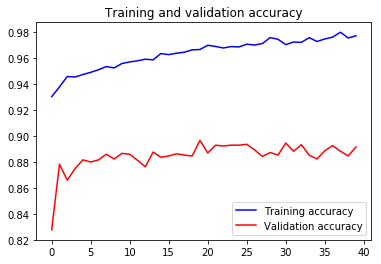

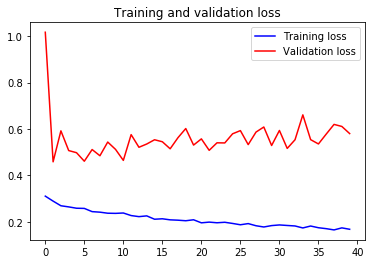

In [0]:
accuracy = copied_low_accuracy_model.history.history['acc']
val_accuracy = copied_low_accuracy_model.history.history['val_acc']
loss = copied_low_accuracy_model.history.history['loss']
val_loss = copied_low_accuracy_model.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
copied_low_accuracy_model.evaluate(valid_X, valid_ground, verbose=0)

[0.5307482582728068, 0.8966666666666666]

In [0]:
#testing
test_eval = copied_low_accuracy_model.evaluate(test_three_data, test_three_label_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])



Test loss: 0.4972803837458293
Test accuracy: 0.9040000001589458


In [0]:
layer_names

['conv8_1']

Mean of DI SCore:  0.5702386197235612
STD of DI Score:  0.059415098660331
MAX of DI Score:  0.6984114818796965


(0, 1.0)

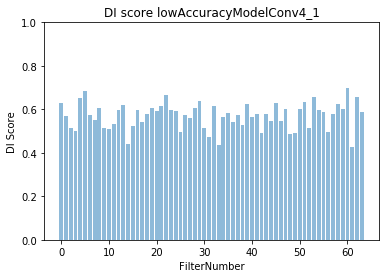

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
#layer_name = layer_to_replace
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_to_replace)

plt.ylim([0,1.0])

Mean of DI SCore:  0.5441455605104493
STD of DI Score:  0.07125697376575997
MAX of DI Score:  0.6857804932152856


(0, 1.0)

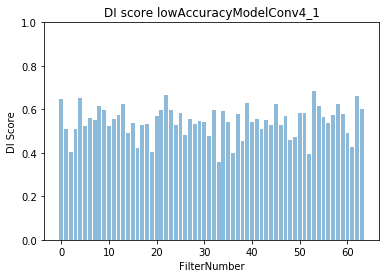

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
#layer_name = 'lowAccuracyModelConv2_1'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_to_replace)

plt.ylim([0,1.0])

Mean of DI SCore:  0.5324752079826454
STD of DI Score:  0.08518245611608953
MAX of DI Score:  0.6952950607026254


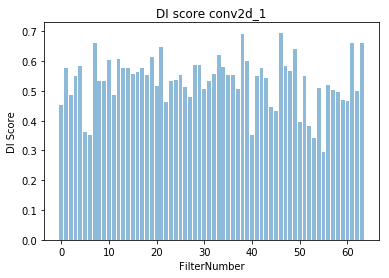

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_1'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.5472756918767483
STD of DI Score:  0.07193005751902407
MAX of DI Score:  0.7008227385646286


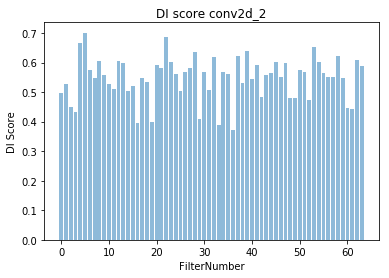

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.4283726311323016
STD of DI Score:  0.11606436878312644
MAX of DI Score:  0.7211856134234298


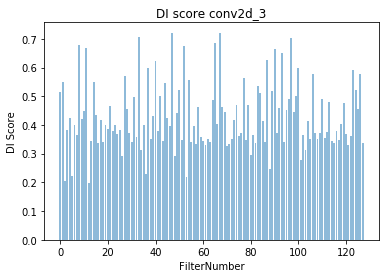

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_3'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

Mean of DI SCore:  0.4676357866426307
STD of DI Score:  0.129639936407154
MAX of DI Score:  0.9082884744169848


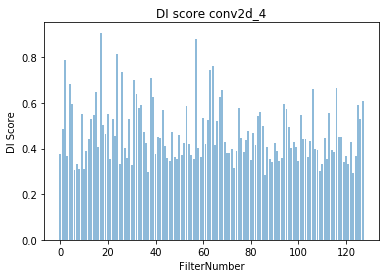

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_4'
discores_low_acc_modified_model = createCNNLayerDIScorePlot(modelFilt, layer_name)

In [0]:
modelFilt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lowAccuracyModelConv1_1 (Con (None, 32, 32, 32)        896       
_________________________________________________________________
lowAccuracyModelBN1 (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
lowAccuracyModelConv2_1 (Con (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________